# NBA Point Spread Regressor Experiments

## Imports

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_point_spead_reg as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy

## Setup

In [144]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


### Utils functions

In [145]:
def filter_from(items, cond):
    return list(filter(cond, items)) 

In [146]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [147]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [19]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [148]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [149]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [150]:
def plot_results(experiment_name, results, figsize=(10,6)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    #     a = sns.pointplot(data=results_df,
    #               kind="point", x="season_test", y="rmse", hue="model"
    #               )
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="mae", hue="model", style="model",
        markers=True, dashes=False
    )
    a.set_title(
        f"{experiment_name}-mae")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [151]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [152]:
reg_metrics = ['mae', 'mse', 'rmse']

def print_prettier_exp_results(exp_name, metric='mae'):
    second_metric = 'rmse' if metric == 'mae' else 'mae'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=True)

## Load Dataset

In [153]:
season_games = sg.load_season_games_dataset()

## Dataset


In [26]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [154]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [155]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 261)
0
(9461, 261)


## Experiments

### Setup

In [156]:
exp_prefix = "reg_"
## exp_group_name = "reg_experiments"
exp_group_name = "reg_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_POINT_SPREAD"
exp_X_columns = model_config.X_REG_COLS_BEST_BORUTA
exp_y_columns = model_config.Y_REG_COL

models = utils_exp.get_reg_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [124]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [125]:
# instantiate random forest
from collections import defaultdict

## RandomForest
model = models[4][1]

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 200, random_state = 0)
list_selected_features = []
for train_idx, test_idx in folds[:]:
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(exp_X_columns)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

BorutaPy(estimator=RandomForestRegressor(max_depth=20, n_estimators=200,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F6EC9A83C00),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F6EC9A83C00)

In [126]:
f_df = dict_to_list(folds_selected_features)

In [141]:
f_df.sort_values(by=[1, 0], ascending=False)
#f_df[f_df[1] > 2]
final_selected_features = list(f_df[0].unique())
sorted(final_selected_features)
final_selected_features

,0,1
4,HOME_PLUS_MINUS_MEAN,7
3,HOME_PLUS_MINUS_L10,7
2,HOME_FT_PCT,7
1,HOME_FG3_PCT,7
7,PLUS_MINUS_MEAN_HOME,3
15,HOME_PLUS_MINUS_ML10,3
11,W_L_CUM_HOME,2
17,PTS_ML10_HOME,2
8,PTS_MEAN_HOME,2
6,HOME_FG_PCT_MEAN,2


['BLK_L10_AWAY',
 'BLK_MEAN_AWAY',
 'BLK_MEAN_HOME',
 'FG_PCT_MEAN_HOME',
 'FG_PCT_ML10_HOME',
 'FT_PCT_L10_AWAY',
 'FT_PCT_ML10_HOME',
 'HOME_FG3_PCT',
 'HOME_FG_PCT_MEAN',
 'HOME_FT_PCT',
 'HOME_PF_ML10',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'PF_ML10_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_HOME',
 'PTS_ML10_HOME',
 'STL_L10_HOME',
 'STL_MEAN_AWAY',
 'STL_MEAN_HOME',
 'W_L_CUM_HOME']

['FT_PCT_L10_AWAY',
 'HOME_FG3_PCT',
 'HOME_FT_PCT',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'PF_ML10_AWAY',
 'HOME_FG_PCT_MEAN',
 'PLUS_MINUS_MEAN_HOME',
 'PTS_MEAN_HOME',
 'STL_MEAN_AWAY',
 'STL_MEAN_HOME',
 'W_L_CUM_HOME',
 'FG_PCT_MEAN_HOME',
 'FT_PCT_ML10_HOME',
 'HOME_PF_ML10',
 'HOME_PLUS_MINUS_ML10',
 'BLK_MEAN_HOME',
 'PTS_ML10_HOME',
 'BLK_L10_AWAY',
 'BLK_MEAN_AWAY',
 'STL_L10_HOME',
 'FG_PCT_ML10_HOME']

In [130]:
f_df.sort_values(by=[1, 0], ascending=False)
#best_boruta = list_selected_features[3]
#sorted(best_boruta)
#best_boruta

,0,1
4,HOME_PLUS_MINUS_MEAN,7
3,HOME_PLUS_MINUS_L10,7
2,HOME_FT_PCT,7
1,HOME_FG3_PCT,7
7,PLUS_MINUS_MEAN_HOME,3
15,HOME_PLUS_MINUS_ML10,3
11,W_L_CUM_HOME,2
17,PTS_ML10_HOME,2
8,PTS_MEAN_HOME,2
6,HOME_FG_PCT_MEAN,2


#### Test best features

In [132]:
#[x for x in exp_X_columns if x not in final_selected_features]
X_boruta = df_sscv[final_selected_features]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name, metric='mae')

Running experiment reg_2_seasons_boruta
Done


KeyError: "['precision_std', 'precision_mean'] not in index"

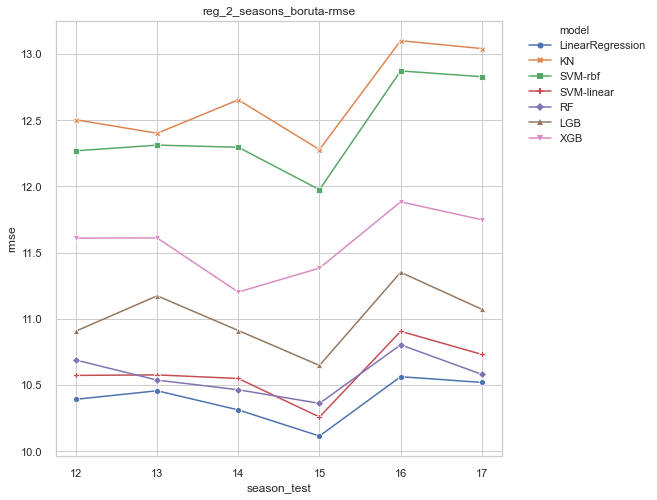

In [133]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

#### Test specific best feature set

In [134]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]

    experiment_name = f"{exp_prefix}2_seasons_boruta_specific_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))
    #print_prettier_exp_results(experiment_name, metric='mae')

Running experiment reg_2_seasons_boruta_specific_0
Done
Running experiment reg_2_seasons_boruta_specific_1
Done
Running experiment reg_2_seasons_boruta_specific_2
Done
Running experiment reg_2_seasons_boruta_specific_3
Done
Running experiment reg_2_seasons_boruta_specific_4
Done
Running experiment reg_2_seasons_boruta_specific_5
Done
Running experiment reg_2_seasons_boruta_specific_6
Done


#### Test custom best feature set

In [ ]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name, metric='mae')

### Experiment using 1 season

In [157]:
experiment_name = f"{exp_prefix}1_season"

In [158]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_1_season
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_1_season,LR,8.256028,0.126807,10.494496,0.178897
3,reg_1_season,RF,8.449477,0.147538,10.738391,0.164168
2,reg_1_season,SVM,8.499833,0.198900,10.870749,0.232820
4,reg_1_season,LGB,8.870632,0.183675,11.230212,0.187991
5,reg_1_season,XGB,9.379288,0.190664,11.886923,0.269304
1,reg_1_season,KNN,9.942533,0.212548,12.640099,0.272066


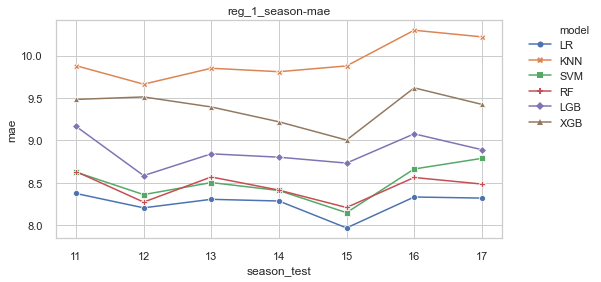

In [159]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment using StandardScaler

In [160]:
experiment_name = f"{exp_prefix}scaled_data"

In [161]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor, StandardScaler())
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_scaled_data
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
6,reg_scaled_data,LR,8.256028,0.126807,10.494496,0.178897
8,reg_scaled_data,SVM,8.316999,0.138790,10.590436,0.184907
9,reg_scaled_data,RF,8.452850,0.143343,10.738799,0.162476
10,reg_scaled_data,LGB,8.783973,0.122858,11.162443,0.134885
7,reg_scaled_data,KNN,9.045967,0.190884,11.482338,0.250083
11,reg_scaled_data,XGB,9.451952,0.192207,11.951730,0.267917


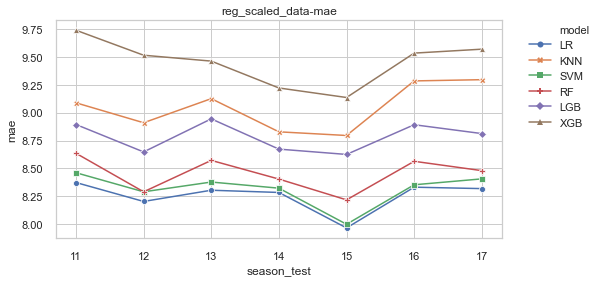

In [162]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment using MinMaxScaler

In [163]:
experiment_name = f"{exp_prefix}minmax_data"

In [164]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor, MinMaxScaler())
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_minmax_data
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
12,reg_minmax_data,LR,8.256028,0.126807,10.494496,0.178897
14,reg_minmax_data,SVM,8.273328,0.109421,10.514554,0.151329
15,reg_minmax_data,RF,8.452063,0.144799,10.738656,0.162281
16,reg_minmax_data,LGB,8.860012,0.148982,11.244225,0.165593
13,reg_minmax_data,KNN,8.969296,0.192312,11.378677,0.215382
17,reg_minmax_data,XGB,9.451267,0.156464,11.935575,0.267995


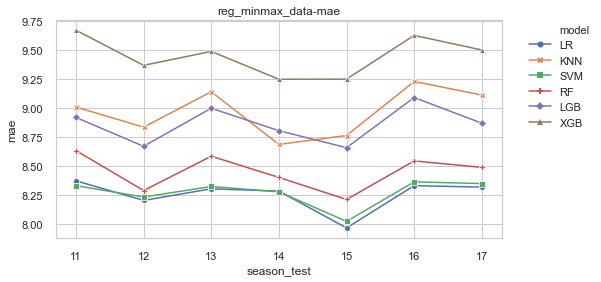

In [165]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 2s; test: 1s

In [190]:
experiment_name = f"{exp_prefix}2_seasons"

In [167]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_2_seasons
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
18,reg_2_seasons,LR,8.192009,0.136491,10.392967,0.148882
20,reg_2_seasons,SVM,8.313091,0.182380,10.599064,0.196440
21,reg_2_seasons,RF,8.345848,0.111711,10.585308,0.150436
22,reg_2_seasons,LGB,8.702064,0.201812,11.010843,0.223081
23,reg_2_seasons,XGB,9.194161,0.189745,11.583278,0.253444
19,reg_2_seasons,KNN,9.952810,0.230096,12.663717,0.310147


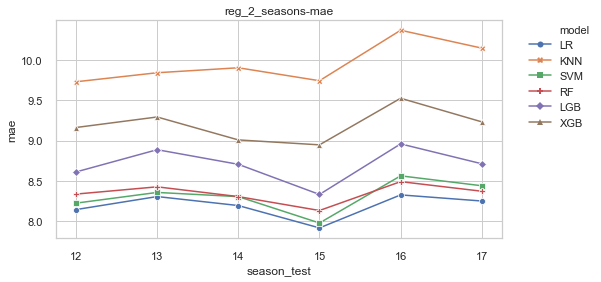

In [191]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 3s; test: 1s

In [192]:
experiment_name = f"{exp_prefix}3_seasons"

In [170]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3_seasons
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
24,reg_3_seasons,LR,8.181175,0.144620,10.372675,0.170107
26,reg_3_seasons,SVM,8.268298,0.181485,10.519299,0.221792
27,reg_3_seasons,RF,8.309049,0.113714,10.524018,0.158028
28,reg_3_seasons,LGB,8.564925,0.182199,10.821560,0.175660
29,reg_3_seasons,XGB,9.096690,0.110708,11.477284,0.124862
25,reg_3_seasons,KNN,10.008543,0.200475,12.710527,0.339452


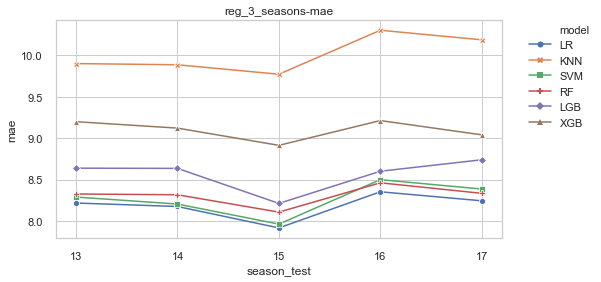

In [171]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment train: 3q ; test: 1q

In [194]:
experiment_name = f"{exp_prefix}3q_1q"

In [173]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_3q_1q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
30,reg_3q_1q,LR,8.302867,0.440110,10.579698,0.577662
33,reg_3q_1q,RF,8.436558,0.360853,10.738740,0.449808
32,reg_3q_1q,SVM,8.596100,0.529849,11.004292,0.664641
34,reg_3q_1q,LGB,8.834862,0.356910,11.200443,0.450785
35,reg_3q_1q,XGB,9.500047,0.422506,11.970499,0.527834
31,reg_3q_1q,KNN,9.890632,0.478864,12.582193,0.563579


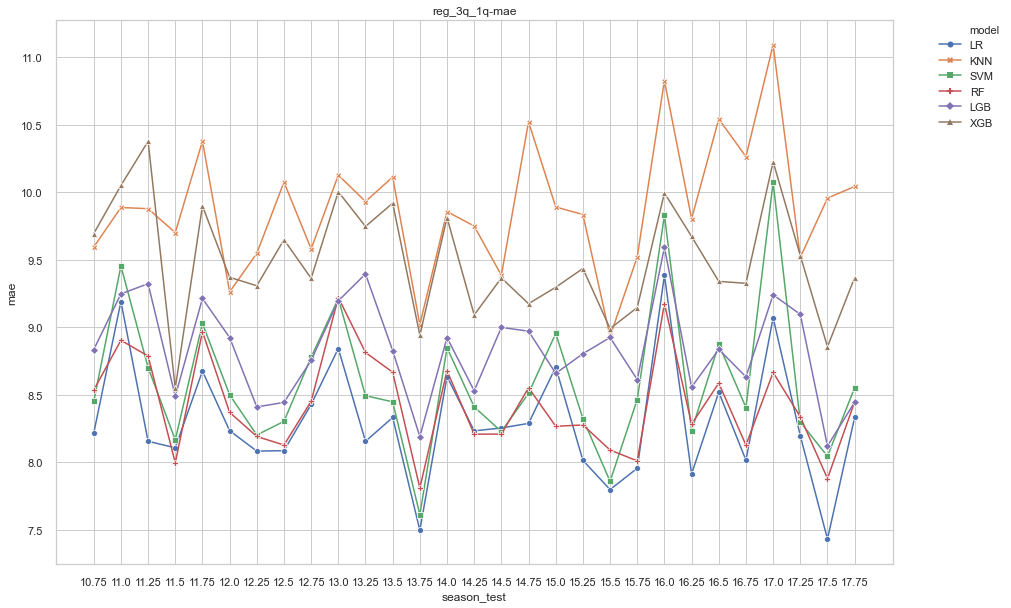

In [198]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

### Experiment train: 4q ; test: 2q

In [199]:
experiment_name = f"{exp_prefix}4q_2q"

In [176]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_4q_2q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
36,reg_4q_2q,LR,8.226138,0.211604,10.443883,0.273616
39,reg_4q_2q,RF,8.401723,0.231675,10.683183,0.269292
38,reg_4q_2q,SVM,8.434612,0.294721,10.773230,0.347890
40,reg_4q_2q,LGB,8.814346,0.229731,11.169320,0.293813
41,reg_4q_2q,XGB,9.333627,0.335198,11.799186,0.391544
37,reg_4q_2q,KNN,9.941826,0.305967,12.640032,0.356854


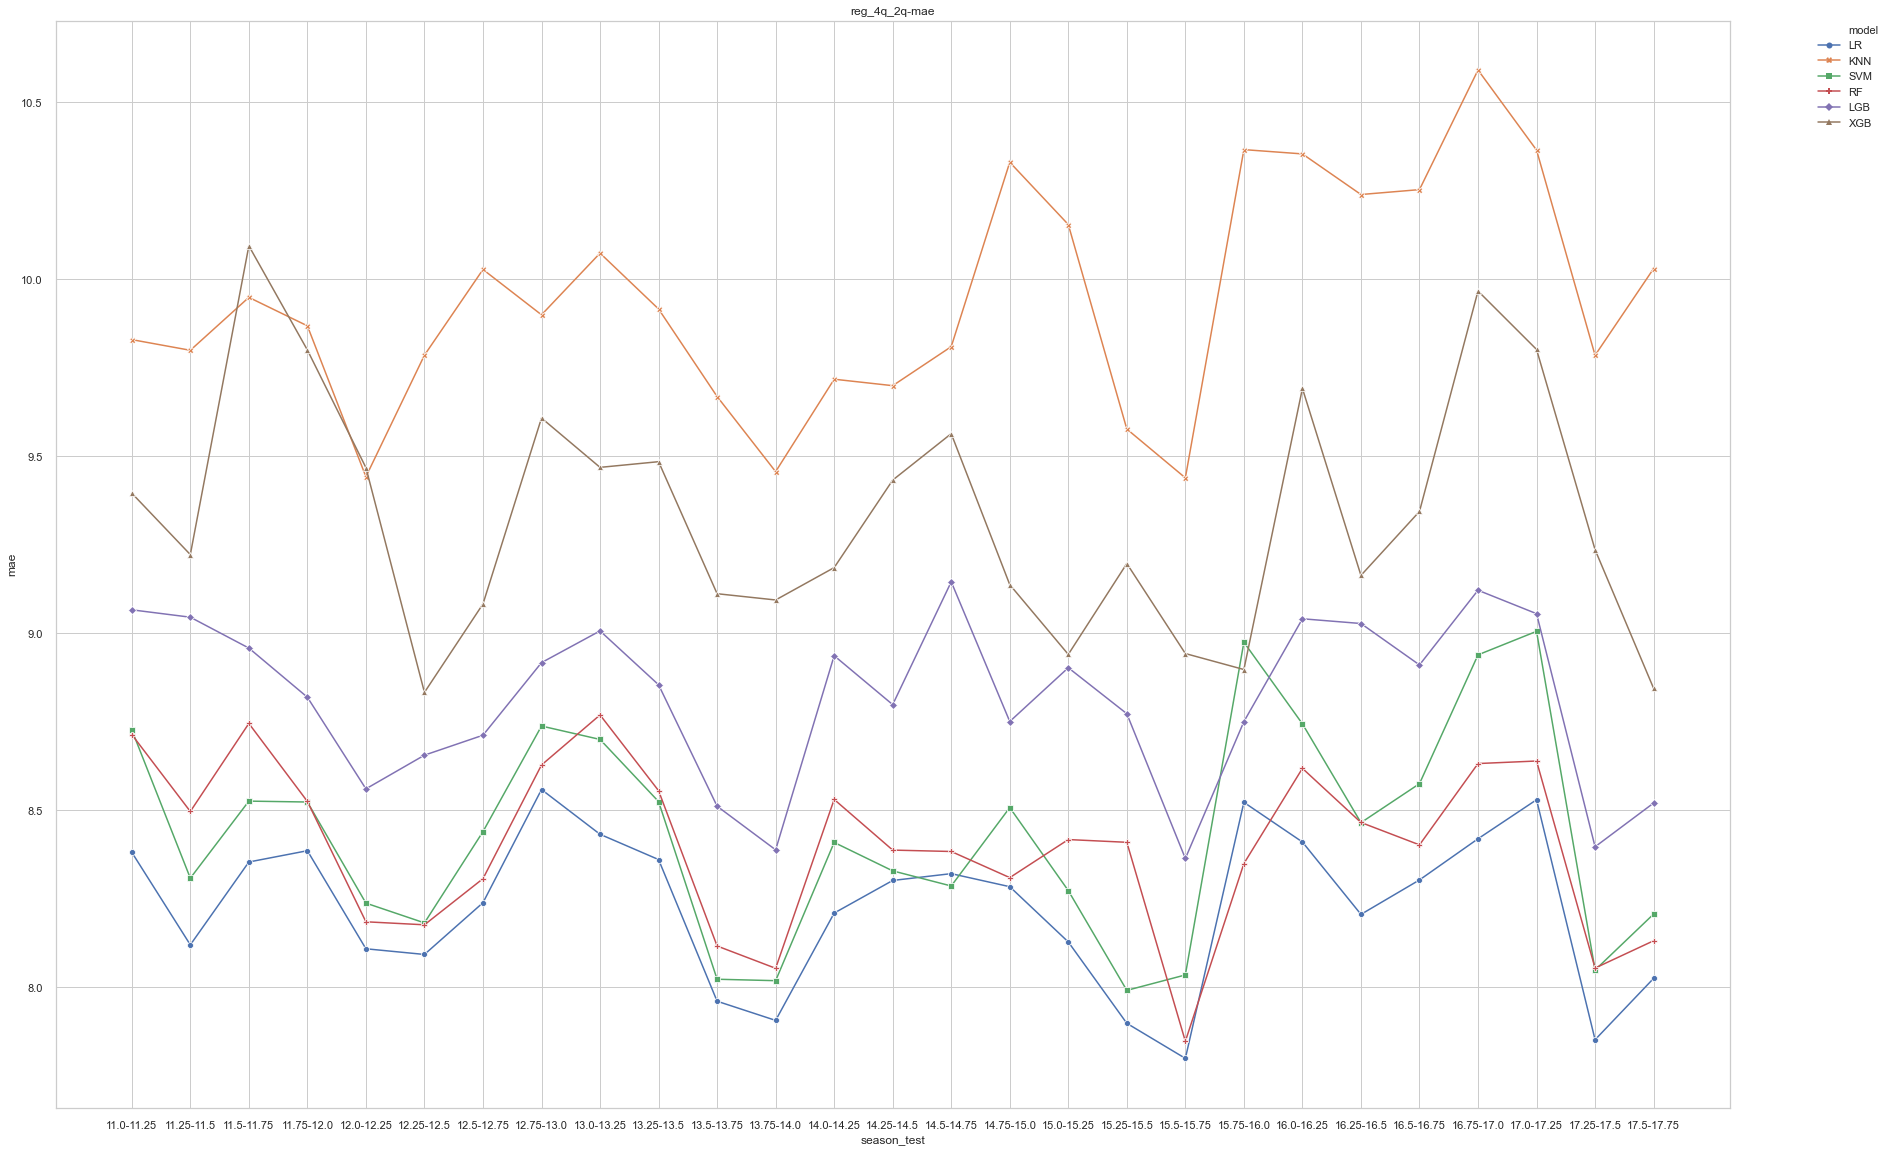

In [204]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30, 20))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [178]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [179]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment reg_r1q_2q_1q
Done


,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
42,reg_r1q_2q_1q,LR,8.330060,0.447199,10.637175,0.600425
45,reg_r1q_2q_1q,RF,8.425610,0.352491,10.723067,0.437200
44,reg_r1q_2q_1q,SVM,8.693169,0.650901,11.147208,0.840049
46,reg_r1q_2q_1q,LGB,8.816092,0.330615,11.186622,0.448481
47,reg_r1q_2q_1q,XGB,9.423062,0.392839,11.911228,0.518256
43,reg_r1q_2q_1q,KNN,9.893475,0.438742,12.592028,0.542044


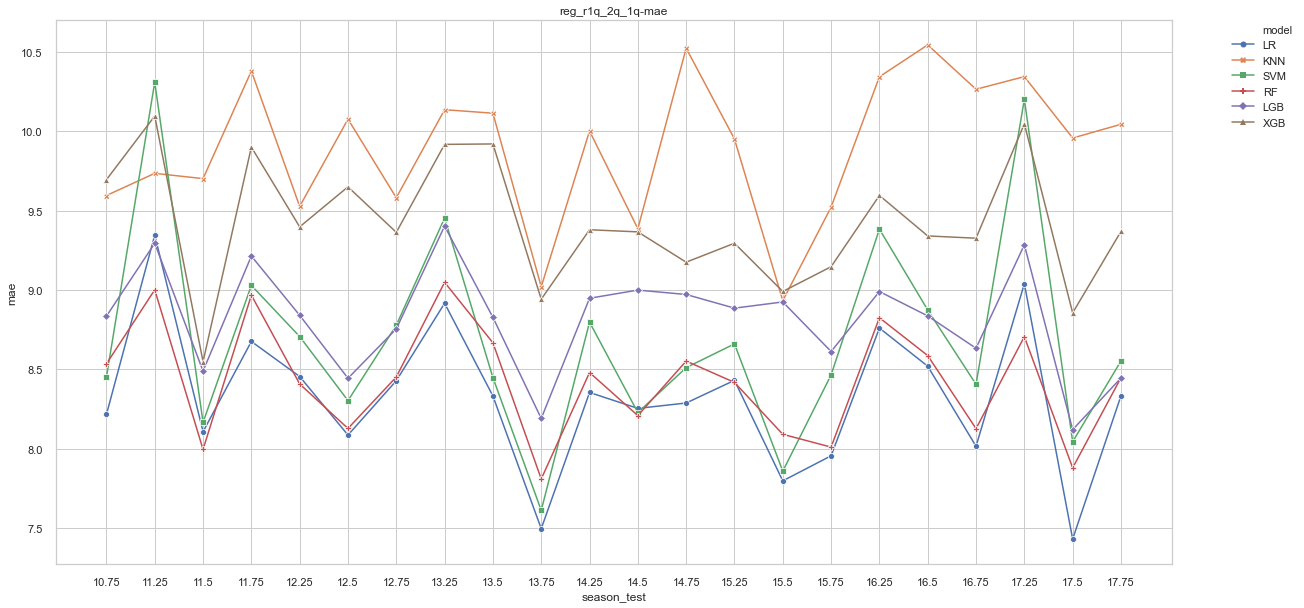

In [180]:
#### Visualize experiments results
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(20,10))

### Experiments comparison

In [181]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)
utils.serialize_object(f'result_totals_{exp_group_name}', results_total)

In [182]:
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = utils.deserialize_object(exp_group_name, [])
exp_df = get_results_df()

In [205]:
ba_df = exp_df[['exp_name', 'model',
       'mae_mean', 'mae_std', 'rmse_mean', 'rmse_std']]

In [184]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [206]:
ba_df.sort_values(
    by=["mae_mean"]
    , ascending=True)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,mae_mean,mae_std,rmse_mean,rmse_std
0,reg_3_seasons,LR,8.181175,0.144620,10.372675,0.170107
1,reg_2_seasons,LR,8.192009,0.136491,10.392967,0.148882
2,reg_4q_2q,LR,8.226138,0.211604,10.443883,0.273616
3,reg_1_season,LR,8.256028,0.126807,10.494496,0.178897
4,reg_minmax_data,LR,8.256028,0.126807,10.494496,0.178897
5,reg_scaled_data,LR,8.256028,0.126807,10.494496,0.178897


### Plot experiment results

#### MAE

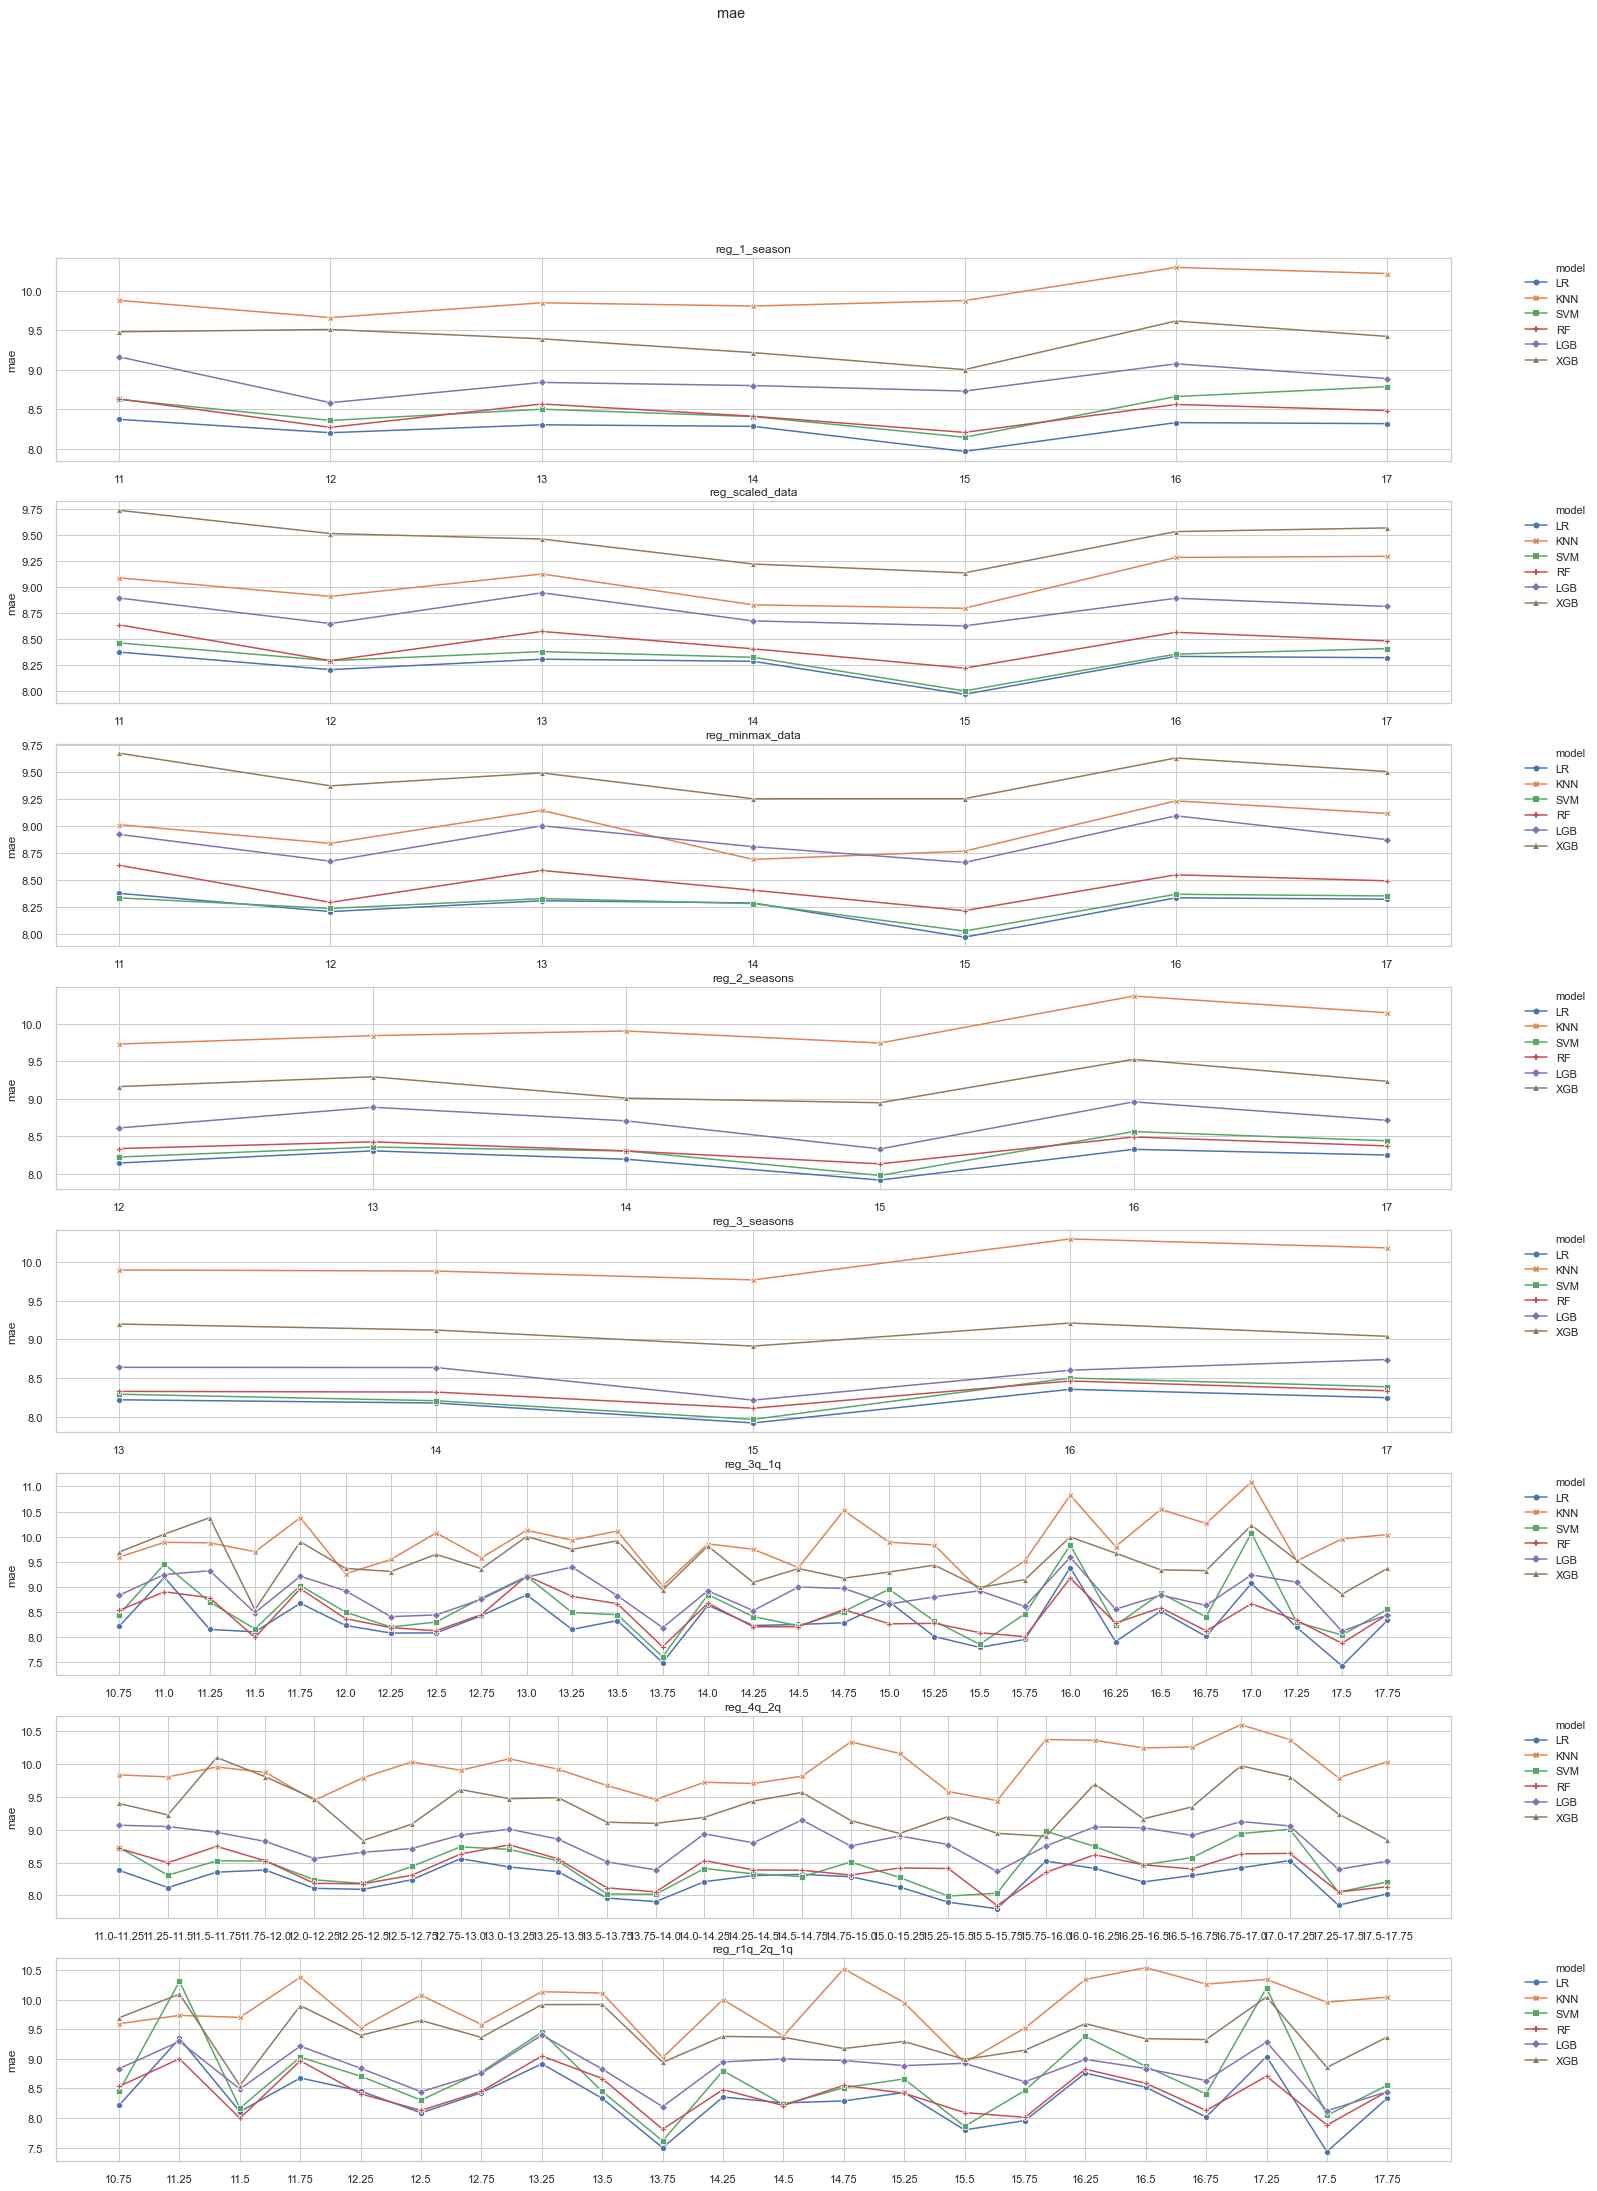

In [186]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mae",
    figsize=(25, 35),
    use_pointplot=True
)

#### MSE

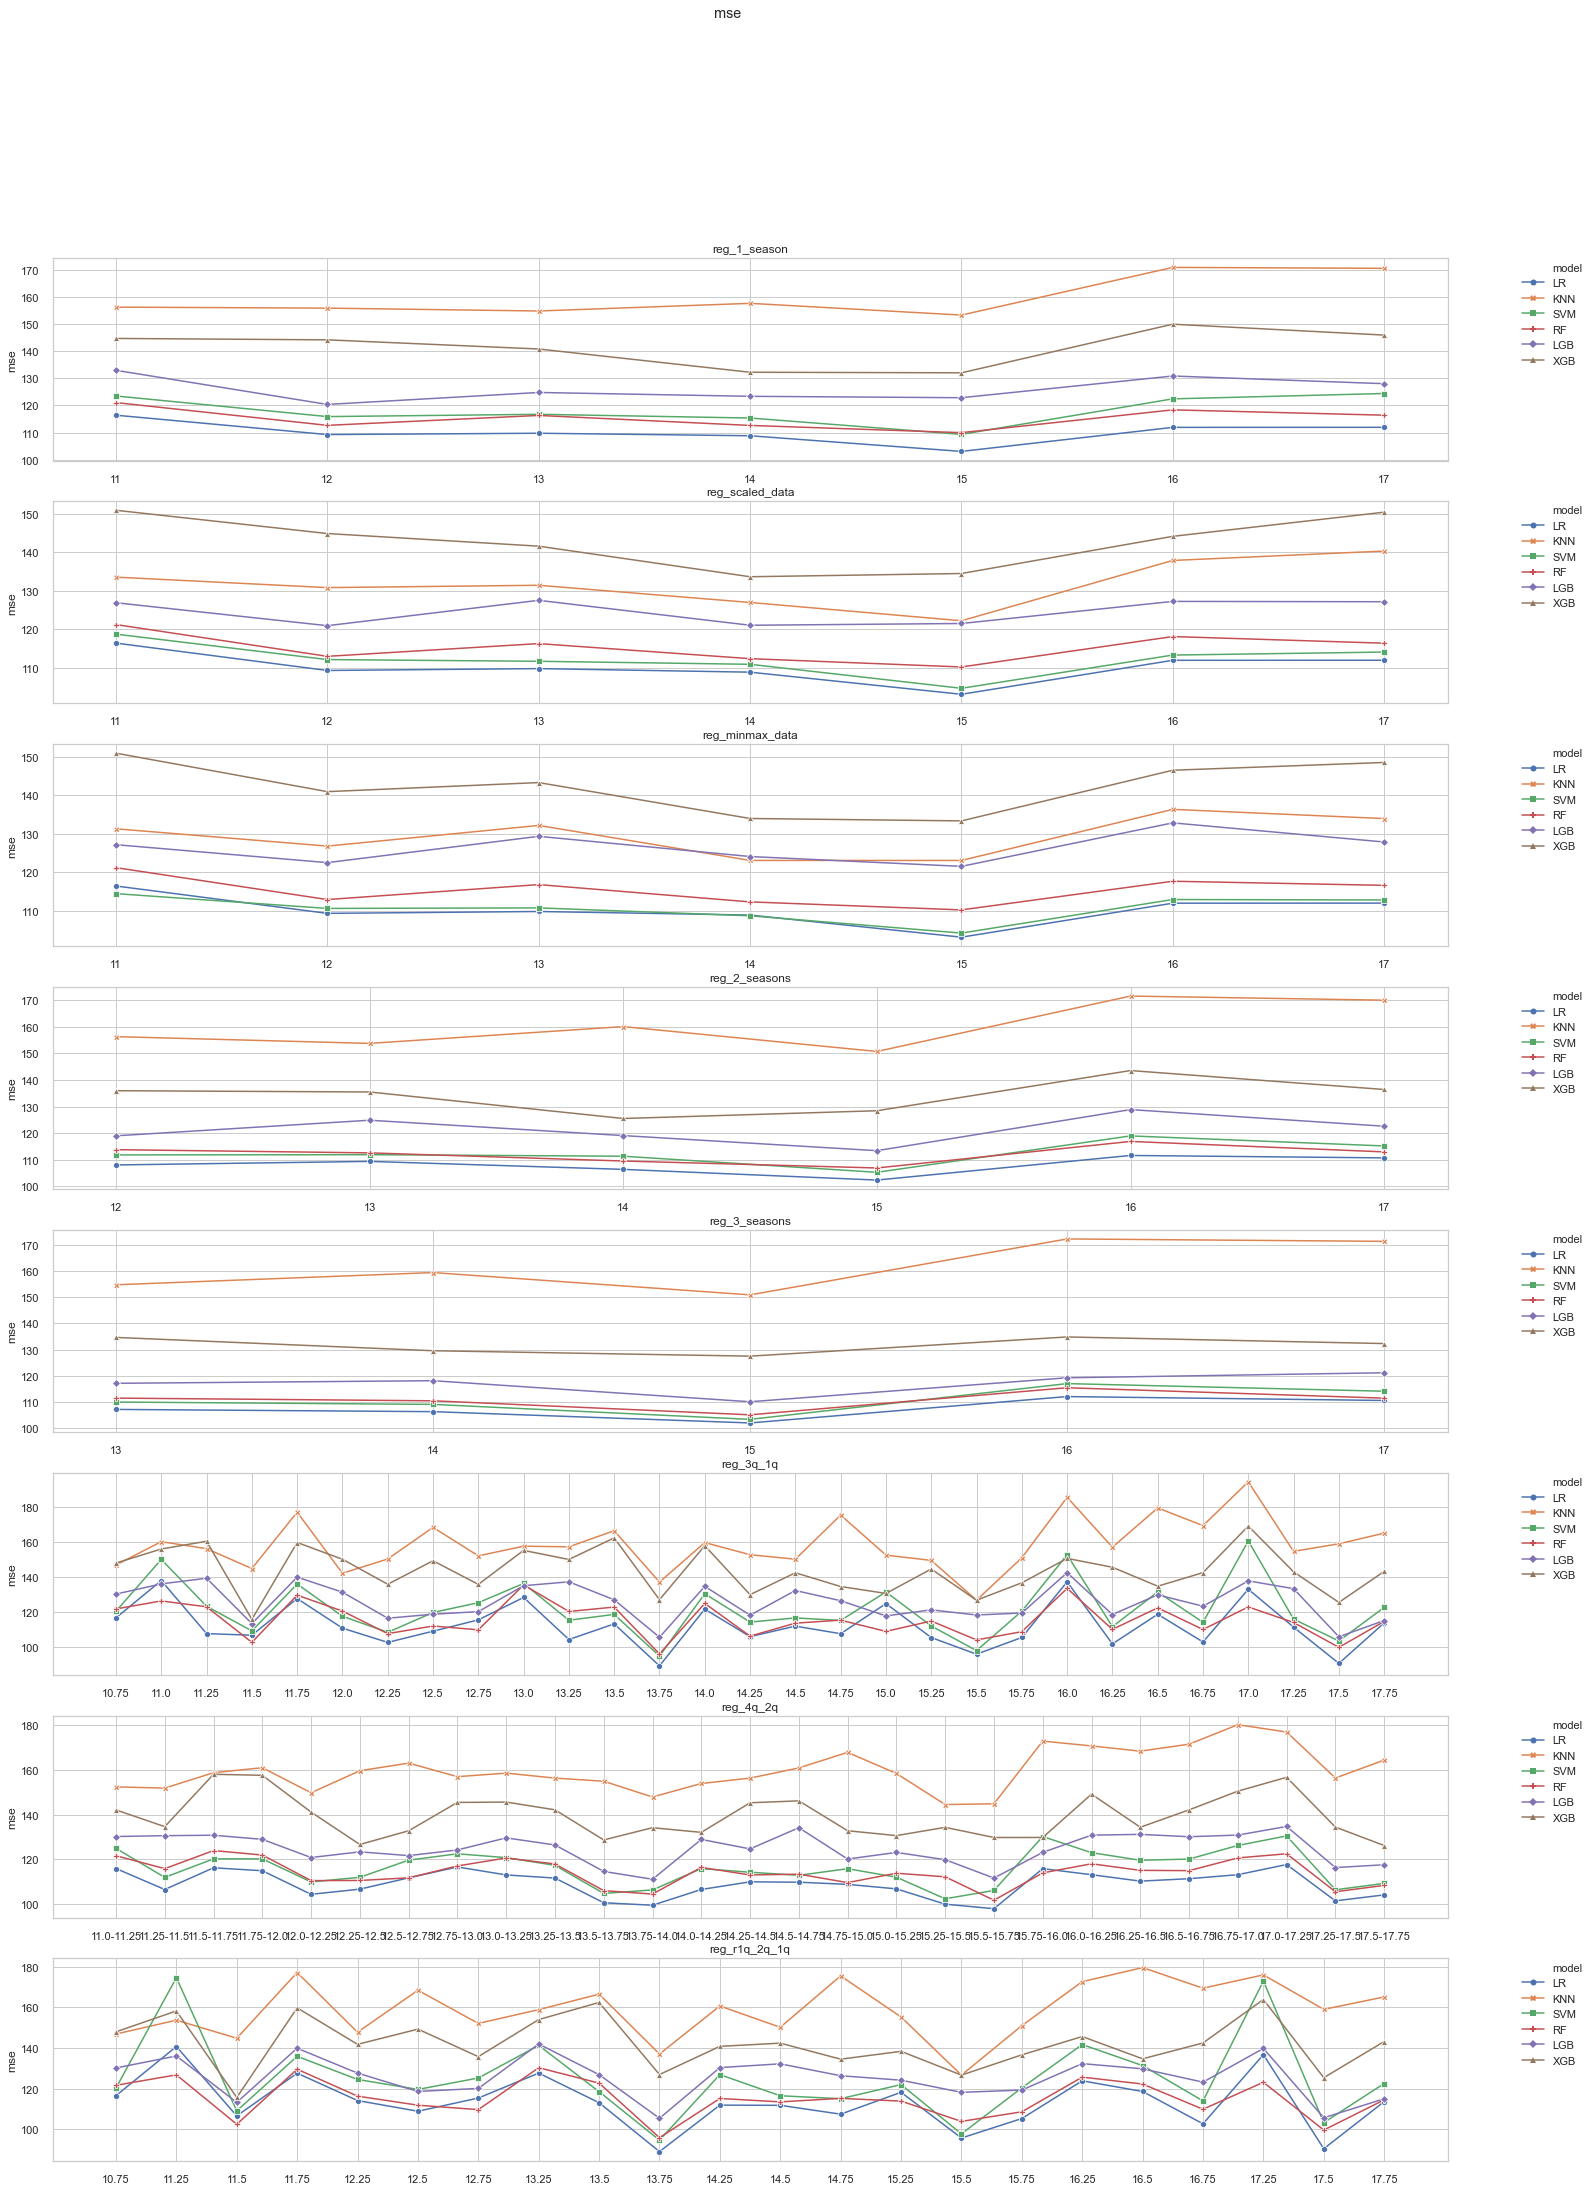

In [187]:
utils.plot_to_compare_experiments(
    results_total,
    metric="mse",
    figsize=(25, 35),
    use_pointplot=True
)

#### RMSE

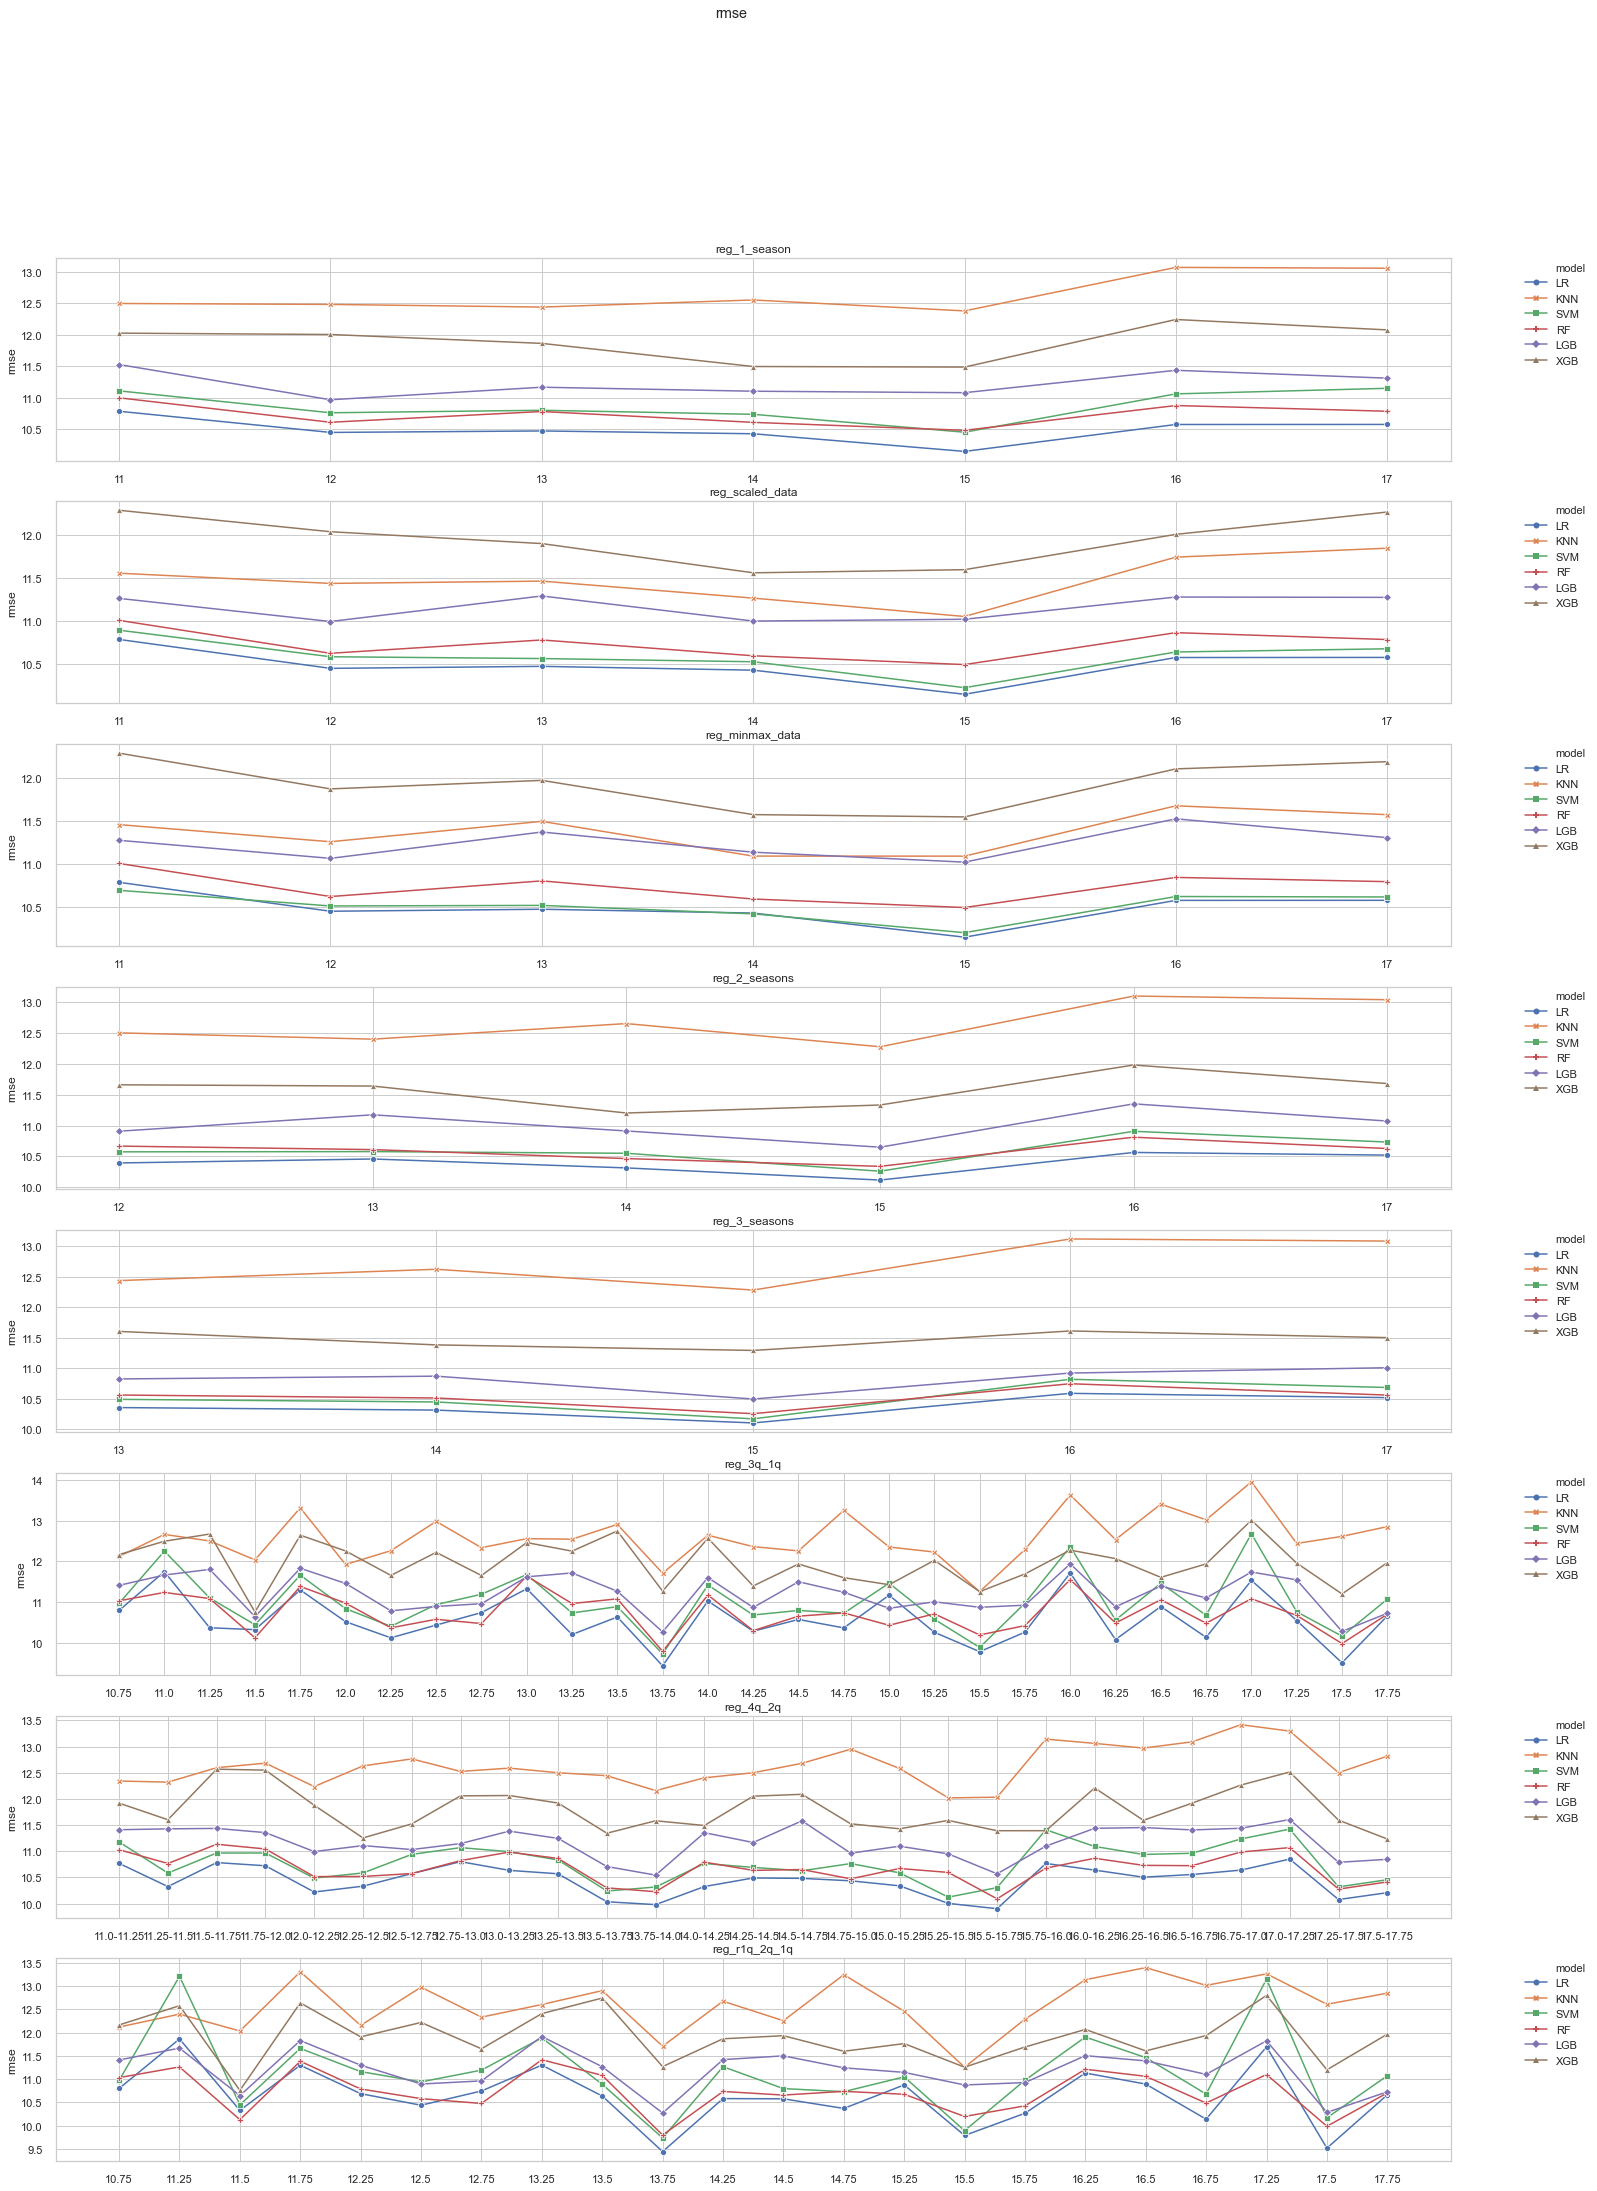

In [188]:
utils.plot_to_compare_experiments(
    results_total,
    metric="rmse",
    figsize=(25, 35),
    use_pointplot=True
)